# Spam email classification for the Enron spam email dataset
## Notebook for experimenting with different Vectorizers and Classifiers

In [12]:
%pip install spacy

import boto3
import os
from pathlib import Path
import numpy as np
import pandas as pd
import re
import spacy
!python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt
import seaborn as sn

from datetime import datetime


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [13]:
region = boto3.Session().region_name
s3_client = boto3.client('s3')

spam_ham_raw_data = Path('/data/raw/')
print(spam_ham_raw_data)

/data/raw


In [14]:
def download_dir(prefix, local, bucket, client=s3_client):
    """
    params:
    - prefix: pattern to match in s3
    - local: local path to folder in which to place files
    - bucket: s3 bucket with target contents
    - client: initialized s3 client object
    """
    keys = []
    dirs = []
    next_token = ''
    base_kwargs = {
        'Bucket':bucket,
        'Prefix':prefix,
    }
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != '':
            kwargs.update({'ContinuationToken': next_token})
        results = client.list_objects_v2(**kwargs)
        contents = results.get('Contents')
        for i in contents:
            k = i.get('Key')
            if k[-1] != '/':
                keys.append(k)
            else:
                dirs.append(k)
        next_token = results.get('NextContinuationToken')
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            print("inside if")
            os.makedirs(os.path.dirname(dest_pathname))
    for k in keys:
        dest_pathname = os.path.join(local, k)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
        client.download_file(bucket, k, dest_pathname)

In [42]:
#download_dir(prefix, local, bucket, client=s3_client)
#download_dir("junk","/data/raw/","nikhil-spam-ham",s3_client)
#download_dir("data/enron1/spam","/root/data/raw/","nikhil-spam-ham",s3_client)
download_dir("data","/root/raw_data/","nikhil-spam-ham",s3_client)
print("done")

done


In [16]:
#print(os.listdir("/root/raw_data/data/"))
#todo path hardcoded

raw_data_path = "/root/raw_data/data/"

X, y = [], []
for subDirectory in os.listdir(raw_data_path):
    subDirectoryPath = Path(os.path.join(raw_data_path, subDirectory))
    if subDirectoryPath.is_dir():
        print("Started loading: " + subDirectory + " - "+datetime.now().strftime("%Y%m%d-%H%M%S"))
        #https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html
        all_data = load_files(os.path.join(raw_data_path, subDirectory))
        X = np.append(X, all_data.data)
        y = np.append(y, all_data.target)
        print("Completed loading: " + subDirectory + " - "+datetime.now().strftime("%Y%m%d-%H%M%S"))
print("done")


Started loading: test - 20221027-192123
Completed loading: test - 20221027-192123
Started loading: enron6 - 20221027-192123
Completed loading: enron6 - 20221027-192128
Started loading: enron2 - 20221027-192128
Completed loading: enron2 - 20221027-192134
Started loading: enron4 - 20221027-192134
Completed loading: enron4 - 20221027-192140
Started loading: train - 20221027-192140
Completed loading: train - 20221027-192141
Started loading: enron3 - 20221027-192141
Completed loading: enron3 - 20221027-192148
Started loading: enron1 - 20221027-192148
Completed loading: enron1 - 20221027-192155
Started loading: validation - 20221027-192155
Completed loading: validation - 20221027-192157
Started loading: enron5 - 20221027-192157
Completed loading: enron5 - 20221027-192205
done


In [18]:
#emails = pd.DataFrame(columns=['label', 'label_name', 'text', 'file_name'])
emails = pd.DataFrame(columns=['spam', 'category', 'message'])
emails['spam'] = [y for y in y]
emails['category'] = emails.apply (lambda row: 'ham' if row.spam == 0 else 'spam', axis=1)
#emails['category'] = emails['spam'].map({'ham':0, 'spam': 1})
emails['message'] = [x for x in X]

In [46]:
#emails.infer_objects()
emails['category'].value_counts()
emails.head()

,spam,category,message,message_preprocessed,vector
0,1.0,spam,"b'Subject: happened mlcros 0 ft , symanntec , ...",subject happen mlcros 0 ft symanntec macromedi...,"[-0.93643135, -0.72902673, -2.809265, 0.397983..."
1,1.0,spam,"b""Subject: hot sale on all win xp products at ...",subject hot sale win xp product ellen s softsh...,"[-0.8308051, -2.2618515, -1.1251718, 1.477813,..."
2,1.0,spam,"b'Subject: gasms for men\r\n"" my girlfriend an...",subject gasm man girlfriend enjoy make homemad...,"[-0.6068439, 0.22185293, -2.5021734, -0.984214..."
3,0.0,ham,b'Subject: re : eog pronghorn location\r\nto a...,subject eog pronghorn location aggressive c pe...,"[-0.91404605, -0.13957796, -1.8296554, -0.3845..."
4,0.0,ham,"b""Subject: transwestern capacity release repor...",subject transwestern capacity release report p...,"[-0.36561504, -1.360887, -0.4424557, 1.2195764..."


In [20]:
def preprocess_email_text(email_text):

    #Remove leading b and new lines
    email_text = re.sub(r'^b', '', email_text)  
    email_text = re.sub(r'\\r\\n', ' ', email_text)

    #Remove stop words, punctuations and lemmetize
    filtered_tokens = []
    doc = nlp(email_text)
    for token in doc:
        if not (token.is_stop or token.is_punct):
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [21]:
emails["message_preprocessed"] = ""
emails.astype({'message_preprocessed': 'string'}).dtypes
emails["message_preprocessed"] = emails["message"].apply(lambda text: preprocess_email_text(str(text)))
#emails["vector"] = emails["message_preprocessed"].apply(lambda text: nlp(text).vector)

In [22]:
emails.infer_objects()
#emails.shape

,spam,category,message,message_preprocessed
0,1.0,spam,"b'Subject: happened mlcros 0 ft , symanntec , ...",subject happen mlcros 0 ft symanntec macromedi...
1,1.0,spam,"b""Subject: hot sale on all win xp products at ...",subject hot sale win xp product ellen s softsh...
2,1.0,spam,"b'Subject: gasms for men\r\n"" my girlfriend an...",subject gasm man girlfriend enjoy make homemad...
3,0.0,ham,b'Subject: re : eog pronghorn location\r\nto a...,subject eog pronghorn location aggressive c pe...
4,0.0,ham,"b""Subject: transwestern capacity release repor...",subject transwestern capacity release report p...
...,...,...,...,...
33711,1.0,spam,"b""Subject: upw presents : meltdown - wednesday...",subject upw present meltdown wednesday july 20...
33712,1.0,spam,"b""Subject: get a head start on a new computer ...",subject head start new computer career focus o...
33713,1.0,spam,b'Subject: legal advice for only pennies\r\nfi...,subject legal advice penny fix bad credit simp...
33714,1.0,spam,b'Subject: claim your home depot gift card - a...,subject claim home depot gift card $ 500 value...


In [23]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
emails_in_csv = Path('/root/raw_data/data/emails_preprocessed.csv')  
emails_in_csv.parent.mkdir(parents=True, exist_ok=True)  
emails.to_csv(emails_in_csv)

In [24]:
# test_emails = ["enhance communication among risk management operations professionals", "get your free adware scan and removal download now "]
# test_emails_cv = v.transform(emails_testing)
# y_pred = model.predict(test_emails_cv)

## Using BOW CountVectorizer and Multinomial Naive based classifier

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      4117
        spam       0.99      0.98      0.99      4312

    accuracy                           0.99      8429
   macro avg       0.99      0.99      0.99      8429
weighted avg       0.99      0.99      0.99      8429



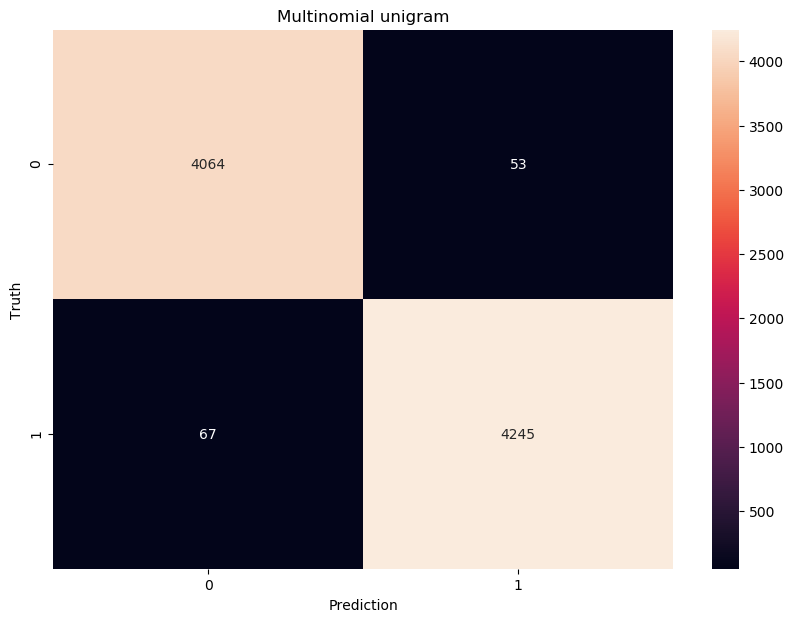

In [27]:
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(
    emails["message_preprocessed"],
    emails["spam"], 
    test_size=0.25,
    random_state=2022
)

pipeline_classifier = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipeline_classifier.fit(X_train, y_train)
pipeline_classifier.score(X_test, y_test)
y_pred=pipeline_classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['ham','spam']))
#X_test_count.toarray()[:5]
#model.score(y_test, y_pred)
#X_train_count.toarray()[:3]
#X_train_count[0]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d').set(title='Multinomial unigram')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

## Using 1 gram and 2 gram BOW CountVectorizer and Multinomial Naive based classifier

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      4117
        spam       0.99      0.99      0.99      4312

    accuracy                           0.99      8429
   macro avg       0.99      0.99      0.99      8429
weighted avg       0.99      0.99      0.99      8429



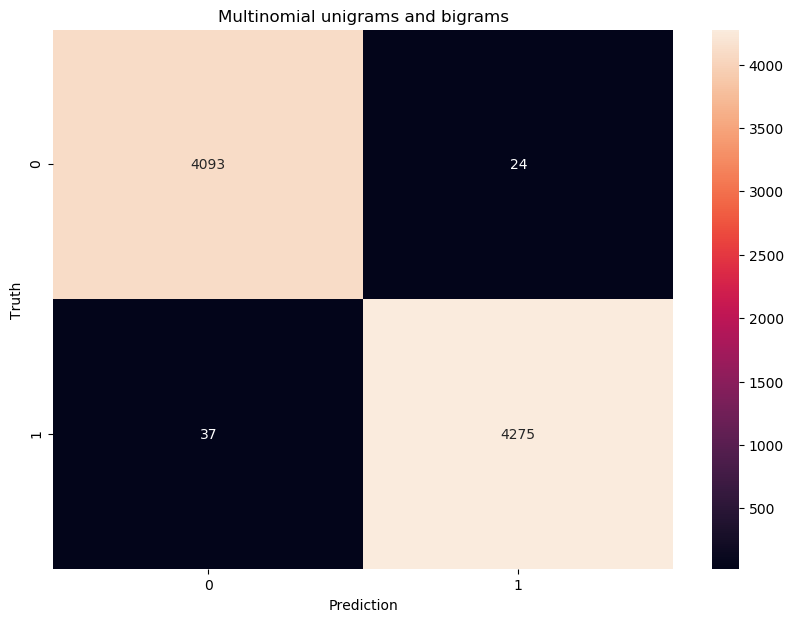

In [28]:
pipeline_classifier_ngram_2 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range = (1, 2))),
    ('nb', MultinomialNB())
])

pipeline_classifier_ngram_2.fit(X_train, y_train)
pipeline_classifier_ngram_2.score(X_test, y_test)
y_pred=pipeline_classifier_ngram_2.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['ham','spam']))
#X_test_count.toarray()[:5]
#model.score(y_test, y_pred)

#X_train_count.toarray()[:3]
#X_train_count[0]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d').set(title='Multinomial unigrams and bigrams')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [29]:
emails['category'].value_counts()

spam    17171
ham     16545
Name: category, dtype: int64

## Using TF-IDF CountVectorizer and KNeighbors classifier

              precision    recall  f1-score   support

         ham       0.96      0.98      0.97      4117
        spam       0.98      0.96      0.97      4312

    accuracy                           0.97      8429
   macro avg       0.97      0.97      0.97      8429
weighted avg       0.97      0.97      0.97      8429



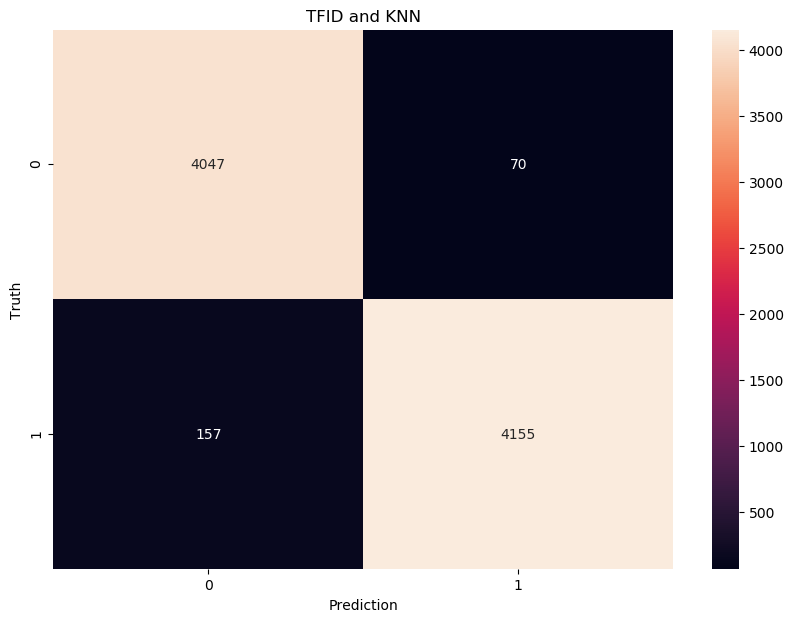

In [30]:
v = TfidfVectorizer()
X_train_cv = v.fit_transform(X_train.values)

KN_classifier = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('KNN', KNeighborsClassifier())
])


KN_classifier.fit(X_train, y_train)
KN_classifier.score(X_test, y_test)
y_pred=KN_classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['ham','spam']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d').set(title='TFID and KNN')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

## Using TF-IDF CountVectorizer and Multinomial classifier

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      4117
        spam       0.99      0.99      0.99      4312

    accuracy                           0.99      8429
   macro avg       0.99      0.99      0.99      8429
weighted avg       0.99      0.99      0.99      8429



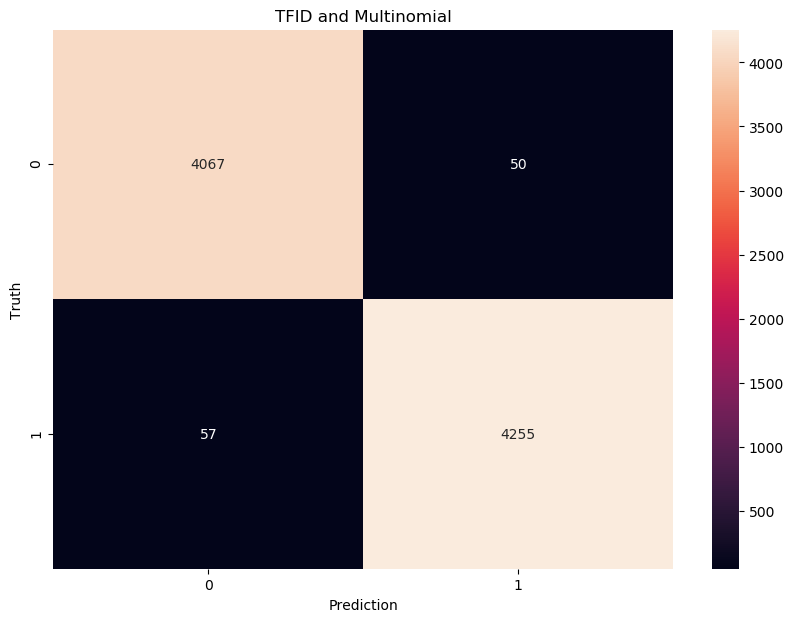

In [31]:
MNB_classifier = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])


MNB_classifier.fit(X_train, y_train)
MNB_classifier.score(X_test, y_test)
y_pred=MNB_classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['ham','spam']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d').set(title='TFID and Multinomial')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

## Using TF-IDF CountVectorizer and Random Forest classifier

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      4117
        spam       0.98      0.99      0.99      4312

    accuracy                           0.99      8429
   macro avg       0.99      0.99      0.99      8429
weighted avg       0.99      0.99      0.99      8429



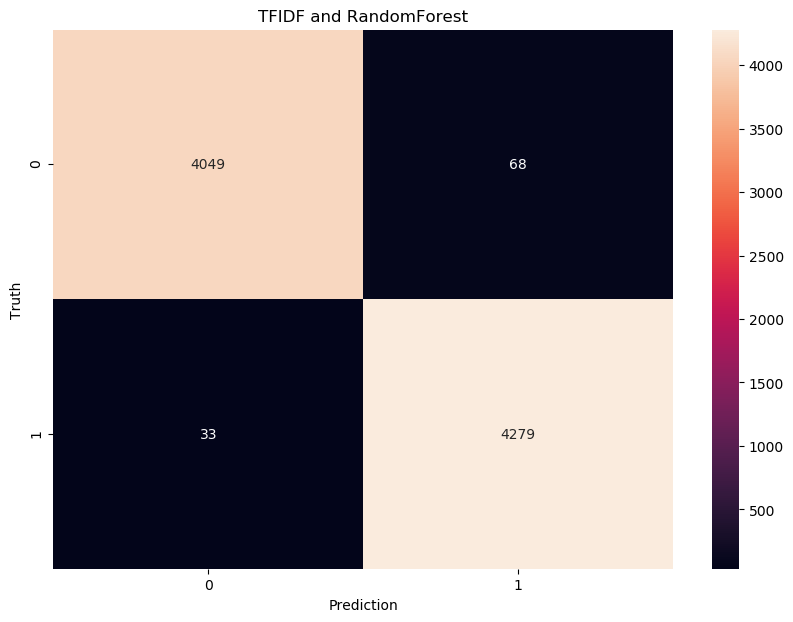

In [40]:
RF_classifier = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('Random Forest', RandomForestClassifier()) 
])


RF_classifier.fit(X_train, y_train)
RF_classifier.score(X_test, y_test)
y_pred=RF_classifier.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['ham','spam']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d').set(title='TFIDF and RandomForest')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [33]:
emails["vector"] = emails["message_preprocessed"].apply(lambda text: nlp(text).vector)

In [34]:
emails.head()

,spam,category,message,message_preprocessed,vector
0,1.0,spam,"b'Subject: happened mlcros 0 ft , symanntec , ...",subject happen mlcros 0 ft symanntec macromedi...,"[-0.93643135, -0.72902673, -2.809265, 0.397983..."
1,1.0,spam,"b""Subject: hot sale on all win xp products at ...",subject hot sale win xp product ellen s softsh...,"[-0.8308051, -2.2618515, -1.1251718, 1.477813,..."
2,1.0,spam,"b'Subject: gasms for men\r\n"" my girlfriend an...",subject gasm man girlfriend enjoy make homemad...,"[-0.6068439, 0.22185293, -2.5021734, -0.984214..."
3,0.0,ham,b'Subject: re : eog pronghorn location\r\nto a...,subject eog pronghorn location aggressive c pe...,"[-0.91404605, -0.13957796, -1.8296554, -0.3845..."
4,0.0,ham,"b""Subject: transwestern capacity release repor...",subject transwestern capacity release report p...,"[-0.36561504, -1.360887, -0.4424557, 1.2195764..."


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    emails["vector"].values,
    emails["spam"],
    test_size=0.25,
    random_state=2022,
)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

              precision    recall  f1-score   support

         ham       0.81      0.66      0.73      4117
        spam       0.73      0.85      0.78      4312

    accuracy                           0.76      8429
   macro avg       0.77      0.76      0.75      8429
weighted avg       0.76      0.76      0.76      8429



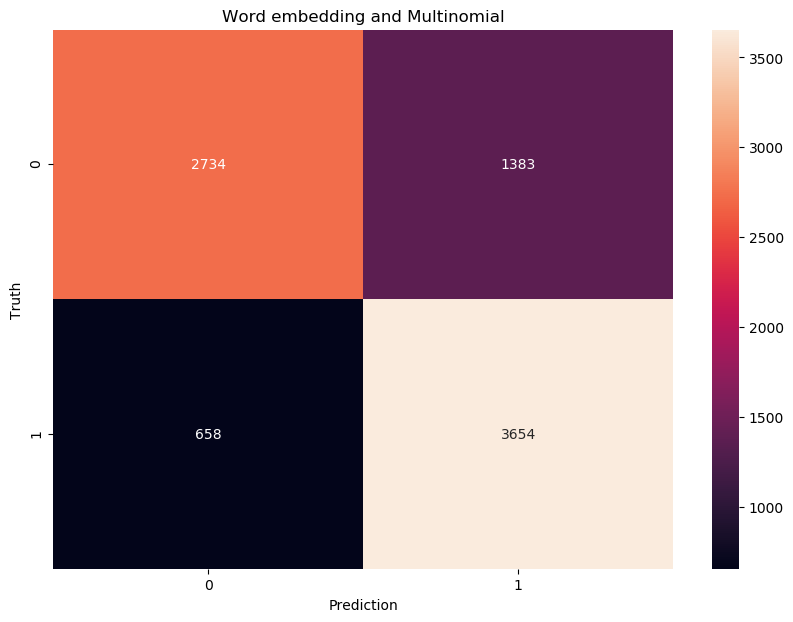

In [36]:
scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

clf = MultinomialNB()
clf.fit(scaled_train_embed,y_train)
y_pred=clf.predict(scaled_test_embed)
print(classification_report(y_test, y_pred, target_names=['ham','spam']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d').set(title='Word embedding and Multinomial')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

              precision    recall  f1-score   support

         ham       0.95      0.94      0.94      4117
        spam       0.94      0.95      0.95      4312

    accuracy                           0.94      8429
   macro avg       0.94      0.94      0.94      8429
weighted avg       0.94      0.94      0.94      8429



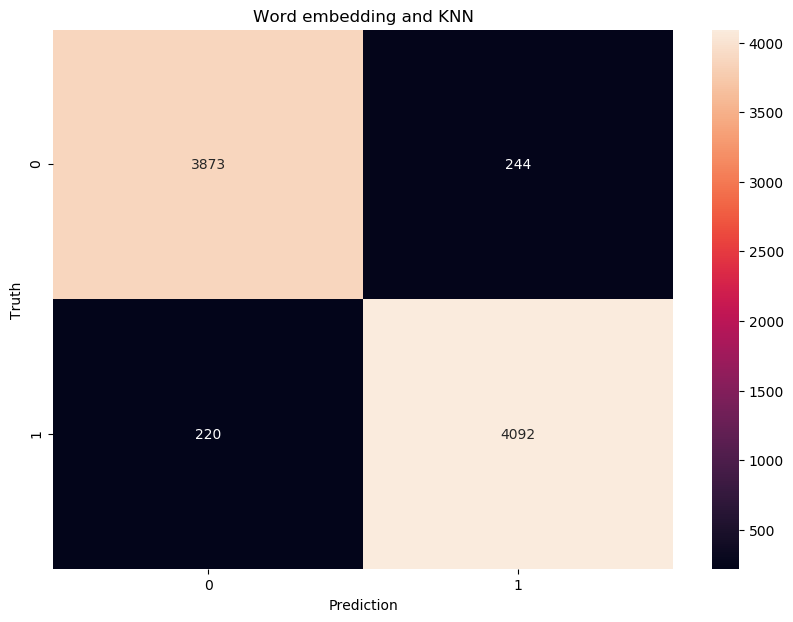

In [37]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)
print(classification_report(y_test, y_pred, target_names=['ham','spam']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d').set(title='Word embedding and KNN')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    emails["message_preprocessed"],
    emails["spam"], 
    test_size=0.25,
    random_state=2022
)

base_path = "/root/raw_data/data/"

try:
    Path(base_path+"train").mkdir(parents=True, exist_ok=False)
    Path(base_path+"validation").mkdir(parents=True, exist_ok=False)
    Path(base_path+"test").mkdir(parents=True, exist_ok=False)
except FileExistsError as fee:
    print("Directory already exists")
    print(fee)
    
print(f"Writing training data set with: {X_train.shape[0]} emails ")
pd.DataFrame(X_train).to_csv(str(Path(base_path+'/train/train.csv').absolute()), header=False, index=False)

print(f"Writing validation data set with: {X_test.shape[0]} emails ")
pd.DataFrame(X_test).to_csv(str(Path(base_path+'/validation/validation.csv').absolute()), header=False, index=False)

print(f"Writing test data set with: {y_test.shape[0]} emails ")
pd.DataFrame(y_test).to_csv(str(Path(base_path+'/test/test.csv').absolute()), header=False, index=False)

Directory already exists
[Errno 17] File exists: '/root/raw_data/data/train'
Writing training data set with: 25287 emails 
Writing validation data set with: 8429 emails 
Writing test data set with: 8429 emails 


In [39]:
emails.shape

(33716, 5)